In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

#### Preprocesamiento de las imagenes

Debido a que el primer enfoque debe ser simple y resolver la problematica con una arquitectura simple de MLP, el dataset actual debe ser previamente tratado ya que tiene etiquetado objetos dentro de cada imagen. Para la arquitectura de MLP no es adecuado un problema de detección de objetos en imagenes, por lo que se utilizará el etiquetado previo para recortar las imagenes y obtener un nuevo dataset con imagenes más pequeñas y con una única categoría por imagen.

In [2]:
path_images = r"C:\Users\Diego\OneDrive\Maestría\MCD\Deep Learning\Proyecto final\Dataset\images"
path_annotations = r"C:\Users\Diego\OneDrive\Maestría\MCD\Deep Learning\Proyecto final\Dataset\annotations"
path_output = r"C:\Users\Diego\OneDrive\Maestría\MCD\Deep Learning\Proyecto final\Dataset\images_processed"

os.makedirs(path_output, exist_ok=True)

for xml_file in os.listdir(path_annotations):
    if not xml_file.endswith(".xml"):
        continue
    
    # Parsear el XML
    xml_path = os.path.join(path_annotations, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Cargar la imagen correspondiente
    nombre_imagen = xml_file.replace(".xml", ".png")
    img_path = os.path.join(path_images, nombre_imagen)
    img = Image.open(img_path)
    
    # Recorrer cada objeto etiquetado
    for i, obj in enumerate(root.findall("object")):
        nombre_clase = obj.find("name").text
        
        # Coordenadas
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        
        # Recortar
        recorte = img.crop((xmin, ymin, xmax, ymax))
        
        # Carpeta por clase
        carpeta_clase = os.path.join(path_output, nombre_clase)
        os.makedirs(carpeta_clase, exist_ok=True)
        
        # Guardar recorte
        recorte.save(os.path.join(carpeta_clase, f"{xml_file[:-4]}_{i}.png"))

#### 1- Preparación y limpieza de datos

In [3]:
# Como usamos modelo basico MLP, extraemos las imagenes y las aplanamos, verificamos despues que existan todas (4072)

# Función para cargar, redimensionar (sin importar si es más grande o más chica) y aplanar
def cargar_y_aplanar_imagenes(image_path, target_size=(128, 128)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)  # redimensiona siempre a target_size
    img = img / 255.0  # Normalizar a [0, 1]
    return tf.reshape(img, [-1])

# Ruta base donde están las carpetas por categoría
ruta_base = r"C:\Users\Diego\OneDrive\Maestría\MCD\Deep Learning\Proyecto final\Dataset\images_processed"

imagenes = []
etiquetas = []

# Recorremos cada carpeta (cada clase)
for clase in os.listdir(ruta_base):
    carpeta_clase = os.path.join(ruta_base, clase)
    if not os.path.isdir(carpeta_clase):
        continue
    
    # Recorremos cada imagen dentro de la carpeta
    for archivo in os.listdir(carpeta_clase):
        if archivo.lower().endswith('.png'):
            ruta_img = os.path.join(carpeta_clase, archivo)
            imagenes.append(cargar_y_aplanar_imagenes(ruta_img))
            etiquetas.append(clase)  # nombre de la carpeta como etiqueta

# Convertimos a tensores/arrays
imagenes = tf.stack(imagenes)  # (num_imagenes, 128*128*3)
etiquetas = np.array(etiquetas)



In [4]:
# Codificamos las etiquetas a números
le = LabelEncoder()
etiquetas_num = le.fit_transform(etiquetas)

# Mostramos info de las clases
for i, clase in enumerate(le.classes_):
    print(f"{clase} : {i}")

# Conteo de elementos por clase
clases, conteos = np.unique(etiquetas_num, return_counts=True)
for clase, conteo in zip(clases, conteos):
    print(f"Clase {clase}: {conteo} elementos")

print(f"Total imágenes cargadas: {len(imagenes)}")

mask_weared_incorrect : 0
with_mask : 1
without_mask : 2
Clase 0: 123 elementos
Clase 1: 3232 elementos
Clase 2: 717 elementos
Total imágenes cargadas: 4072


C:\Users\Diego\AppData\Local\Temp\ipykernel_9988\579922910.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=etiquetas_num, palette='Set1')


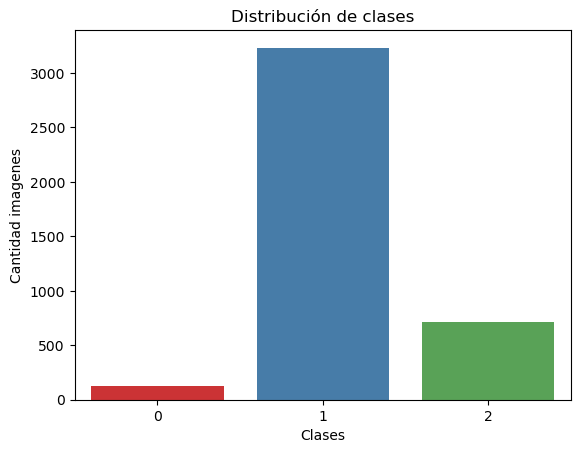

In [5]:
sns.countplot(x=etiquetas_num, palette='Set1')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad imagenes')
plt.show()

#### 2- Creación del modelo

In [6]:
imagenes_tensor = tf.convert_to_tensor(imagenes)

X_train, X_test, y_train, y_test = train_test_split(
    imagenes_tensor.numpy(), etiquetas_num, test_size=0.2, random_state=42, stratify=etiquetas_num)

print(f"\nTamaño de datos de entrenamiento: {X_train.shape[0]}")
contador_train = Counter(y_train)
for clase, cantidad in contador_train.items():
    print(f"Clase {clase}: {cantidad} imagenes")


Tamaño de datos de entrenamiento: 3257
Clase 1: 2585 imagenes
Clase 2: 574 imagenes
Clase 0: 98 imagenes


In [7]:
# función para reducir la clase 1 al 40% de su tamaño original
def balancear_dataset(X, y, target_class=1, reduction_factor=0.4):
    indices_clase_0 = np.where(y == 0)[0]
    indices_clase_1 = np.where(y == 1)[0]
    indices_clase_2 = np.where(y == 2)[0]
    np.random.seed(42)
    n_samples_clase_1 = int(len(indices_clase_1) * reduction_factor)
    indices_clase_1_reducidos = np.random.choice(indices_clase_1, size=n_samples_clase_1, replace=False)
    indices_balanceados = np.concatenate([indices_clase_0,indices_clase_1_reducidos,indices_clase_2])
    np.random.shuffle(indices_balanceados)
    
    return X[indices_balanceados], y[indices_balanceados]

In [8]:
# Aplico la función al cnjunto de train
X_train_balanced, y_train_balanced = balancear_dataset(X_train, y_train, target_class=1, reduction_factor=0.4)

print("\nNueva distribución en conjunto de entrenamiento:")
contador_balanced = Counter(y_train_balanced)
for clase, cantidad in contador_balanced.items():
    print(f"Clase {clase}: {cantidad} imagenes")

print(f"\nTamaño final de entrenamiento: {X_train_balanced.shape[0]} obs.")


Nueva distribución en conjunto de entrenamiento:
Clase 1: 1034 imagenes
Clase 2: 574 imagenes
Clase 0: 98 imagenes

Tamaño final de entrenamiento: 1706 obs.


In [9]:
y_train_onehot = to_categorical(y_train_balanced, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_onehot))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_balanced)).batch(32, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot)).batch(32, drop_remainder=True)

In [10]:
# Modelo Perceptron Multicapa (MLP)
def MLPClasificador_Keras():
    model = Sequential()
    model.add(InputLayer(shape=(128*128*3,))) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # 3 clases

    return model

In [11]:
mlp_Keras = MLPClasificador_Keras()

In [12]:
# Compilar el modelo
mlp_Keras.compile(loss='categorical_crossentropy',
            optimizer=SGD(),
            metrics=['accuracy'])

# Entrenar el modelo
history = mlp_Keras.fit(X_train_balanced.astype(float), y_train_onehot,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5579 - loss: 1.2411 - val_accuracy: 0.6637 - val_loss: 0.7194
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6891 - loss: 0.7160 - val_accuracy: 0.7836 - val_loss: 0.5526
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7683 - loss: 0.6140 - val_accuracy: 0.8363 - val_loss: 0.4298
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8006 - loss: 0.5783 - val_accuracy: 0.8596 - val_loss: 0.4196
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8314 - loss: 0.4886 - val_accuracy: 0.8450 - val_loss: 0.4326
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8519 - loss: 0.4725 - val_accuracy: 0.8947 - val_loss: 0.3515
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8717 - loss: 0.4322 - val_accuracy: 0.8801 - val_loss: 0.3847
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8614 - loss: 0.4474 - val_accuracy: 0.9006 - v

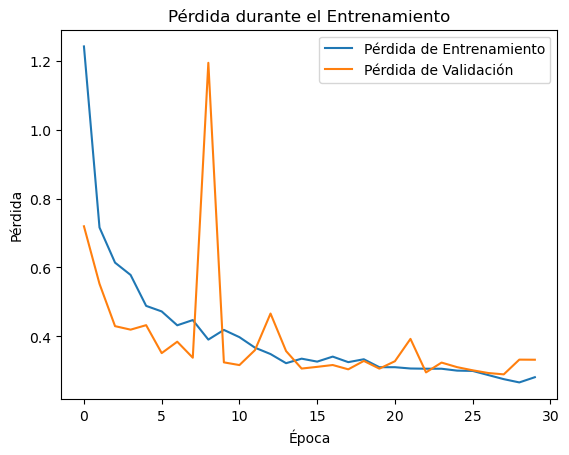

In [13]:
def plot_loss_historia_keras(history):
    # Graficar el histórico de pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    
plot_loss_historia_keras(history)

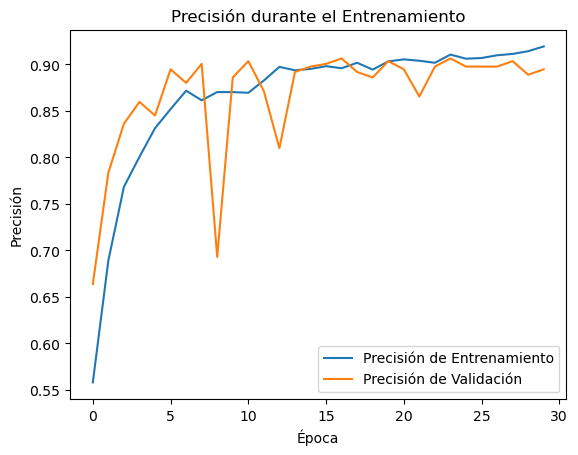

In [14]:
def plot_acc_historia_keras(history):
    # Graficar la precisión durante el entrenamiento
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

plot_acc_historia_keras(history)

In [15]:
score = mlp_Keras.evaluate(X_test.astype(float), y_test_onehot, batch_size=32)

score

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9288 - loss: 0.2367


[0.23674975335597992, 0.9288343787193298]

In [16]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp_Keras.predict(X_test.astype(float))

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test_onehot.astype(int)  # Las etiquetas reales del conjunto de prueba

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Reporte de Clasificación para el MLP de facemask:

              precision    recall  f1-score   support

           0       0.44      0.16      0.24        25
           1       0.95      0.97      0.96       647
           2       0.86      0.88      0.87       143

    accuracy                           0.93       815
   macro avg       0.75      0.67      0.69       815
weighted avg       0.92      0.93      0.92       815



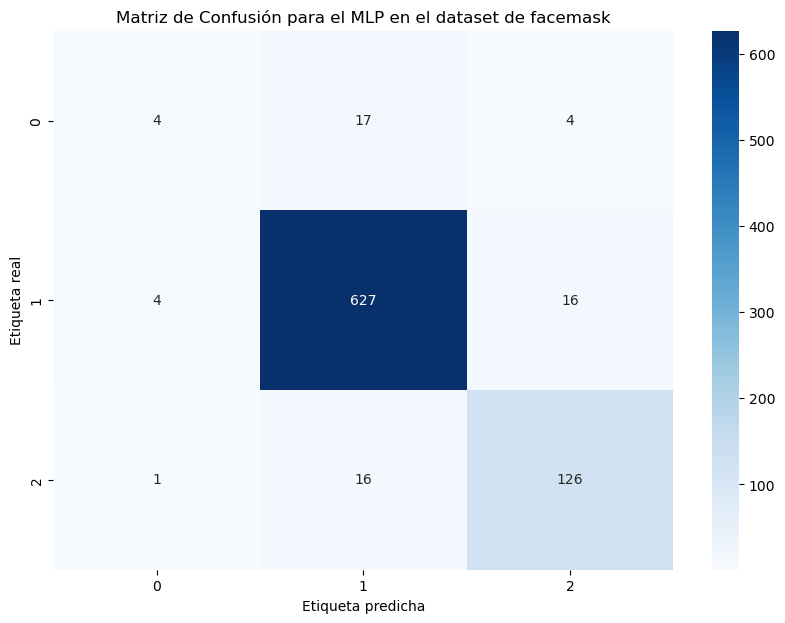

In [17]:
def plot_matriz_confusion(cm):
    # Visualizar la matriz de confusión usando Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title('Matriz de Confusión para el MLP en el dataset de facemask')
    plt.show()

# Generar el reporte de clasificación
print("Reporte de Clasificación para el MLP de facemask:\n")
y_true_labels = np.argmax(y_true, axis=1)
print(classification_report(y_true_labels, y_pred_classes))

# Crear la matriz de confusión
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Visualizar la matriz de confusión usando Seaborn
plot_matriz_confusion(cm)